In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

filepath = './sunspot.txt'

data = pd.read_csv(filepath, sep=' ', skipinitialspace=True, index_col = 0, header=None) #parse_dates=[0]

stack = data.stack()

new_index=stack.index.map(lambda x: datetime.datetime(x[0],x[1],1,0,0))
data = pd.Series(stack.values, index=new_index.values)

data.index.name = 'date'

test = data.iloc[data.index.get_loc('2010-01-01')-20:-1]
train = data[:'2009']

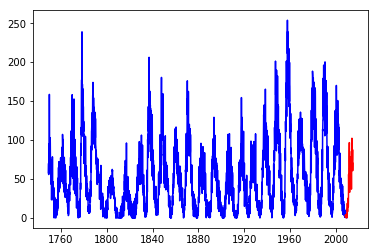

In [2]:
%matplotlib inline
plt.plot(train, color='blue')
plt.plot(test, color='red')
plt.show()

## (a)

#### Algorithm to transform the time series format to a supervised problem format

In [3]:
data_array = train.values
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data_array, K=1):
    X = np.array([])
    Y = np.array([])

    for i in range(len(data_array)-K):
        X = np.append(X, data_array[i:K+i])
        Y = np.append(Y, data_array[K+i])
    X = X.reshape((-1,K))
    return (X, Y)

X_train, Y_train = series_to_supervised(train.values, 20)
X_test, Y_test = series_to_supervised(test.values, 20)

#### Training and predicting using Linear Regression

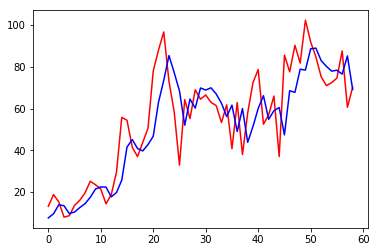

Mean Squared Error: 212.263723 
R2: 0.670314


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression(fit_intercept=False)
lr = lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

%matplotlib inline
# plt.figure(1)
plt.plot(Y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()

print("Mean Squared Error: %f \nR2: %f" % (mean_squared_error(Y_test,y_pred), r2_score(Y_test,y_pred)))


## (b)

1. Starting with K=20 and do a k-fold division of training data
1. Using a wrapper strategy find the better set of variables to predict the data
1. Use Ridge Regression to predict
1. Use RMSE to compair the performance

In [5]:
# Using Ridge Regression with cross-validation for choose alpha implemented at scikit package
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=np.logspace(-20,5,20), cv=5, scoring='neg_mean_squared_error').fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print("RMSE for Ridge Regression: %f" % mean_squared_error(clf.predict(X_test),Y_test))
# clf.alpha_

0.6792434508201349
RMSE for Ridge Regression: 206.514450


#### Implementing of the wrapper with backward regression, using cross validation for choose alpha

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

ALPHA_LIST = np.logspace(-20,3,200)
N_OF_VARIABLES = 20

np.random.seed(42)
perm_array = np.random.permutation(len(Y_train)) # for permute the training dataset
kf = KFold(n_splits=5)


starting_variables = [i for i in range(N_OF_VARIABLES)]

all_results = {}
while len(starting_variables)>1:
    variables = starting_variables[:]
    n_var = len(variables) - 1
    for i in range(n_var):
        v = variables[:]
        out_variable = v.pop(i)
        error = []
        # Find the best alpha in the list for Ridge Regression
        for alpha in ALPHA_LIST:
            lrr = Ridge(alpha=alpha)
            error_kf=set()
            for train, test in kf.split(X_train):
                lrr.fit(X_train[perm_array][train][:,v],Y_train[perm_array][train])
                error_kf.add(mean_squared_error(Y_train[perm_array][test],lrr.predict(X_train[perm_array][test][:,v])))
            error.append({'mean':min(error_kf), 'alpha':alpha})
        # Add error for each set of variables
        if n_var not in all_results:
            all_results[n_var] = [{
                "error": min(error, key=lambda x:x['mean']), 
                "variables": v[:],
                "out_variable" : out_variable
            }]
        else:
            all_results[n_var].append({
                "error": min(error, key=lambda x:x['mean']), 
                "variables": v[:],
                "out_variable" : out_variable
            })
    best_with_k_varibles = min(all_results[n_var], key=lambda x:x['error']['mean'])
    # remove the variable that most deteriorate the regression
    starting_variables.remove(best_with_k_varibles['out_variable'])

	Error		alpha	Variables
	205.245914	1.0e+03	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
	204.349968	1.0e+03	[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
	203.434101	1.0e+03	[0, 1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
	203.067019	1.0e+03	[0, 1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19]
	202.473981	1.0e+03	[0, 1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19]
	202.084052	1.0e+03	[0, 1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 17, 18, 19]
	201.759573	1.0e+03	[1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 17, 18, 19]
	201.492573	1.0e+03	[1, 3, 4, 6, 7, 10, 11, 13, 14, 17, 18, 19]
	201.311618	1.0e+03	[1, 4, 6, 7, 10, 11, 13, 14, 17, 18, 19]
	201.417004	1.0e+03	[1, 4, 6, 7, 10, 11, 14, 17, 18, 19]
	201.631670	1.0e+03	[1, 4, 6, 10, 11, 14, 17, 18, 19]
	201.535092	1.0e+03	[1, 4, 10, 11, 14, 17, 18, 19]
	201.993158	1.0e+03	[1, 4, 11, 14, 17, 18, 19]
	202.705356	1.0e+03	[1, 11, 14, 17, 18, 19]
	205.684833	1.0e+03	[1, 11, 14, 17, 19]
	209.899537	1.

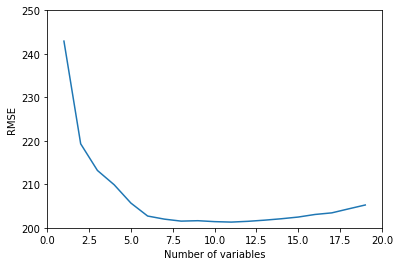



Best Predictor at train dataset
Error:	201.311618
Variables:	[1, 4, 6, 7, 10, 11, 13, 14, 17, 18, 19]
alpha:	1.0e+03


In [7]:
# Show the results
print("\tError\t\talpha\tVariables")
min_var=[]
error_plot=[]
n_variables_plot=[]
for n_var in all_results:
    min_var_ = min(all_results[n_var], key=lambda x:x['error']['mean'])
    min_var.append(min_var_)
    error_plot.append(min_var_['error']['mean'])
    n_variables_plot.append(len(min_var_['variables']))
    print("\t%f\t%.1e\t%s" % (min_var_['error']['mean'], min_var_['error']['alpha'],min_var_['variables']))

%matplotlib inline
plt.plot(n_variables_plot, error_plot)
plt.axis([0, 20, 200, 250])
plt.xlabel('Number of variables')
plt.ylabel('RMSE')
plt.show()


best_predictor = min(min_var, key=lambda x: x['error']['mean'])
print("\n\nBest Predictor at train dataset\nError:\t%f\nVariables:\t%s\nalpha:\t%.1e" % (best_predictor['error']['mean'], best_predictor['variables'], best_predictor['error']['alpha']))

#### Best prediction for variables discovered by the wrapper

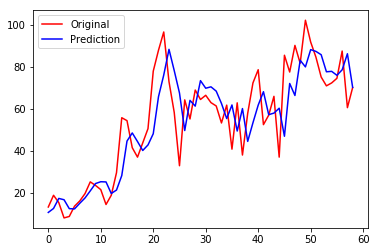

Test dataset
Mean Squared Error: 204.508248 
R2: 0.682359


In [8]:
# best_predictor
lrr = Ridge(alpha=best_predictor['error']['alpha'])
lrr.fit(X_train[:,best_predictor['variables']],Y_train)

y_pred = lrr.predict(X_test[:,best_predictor['variables']])

%matplotlib inline

plt.plot(Y_test, color='red', label='Original')
plt.plot(y_pred, color='blue', label='Prediction')
plt.legend()
plt.show()

print("Test dataset")
print("Mean Squared Error: %f \nR2: %f" % (mean_squared_error(Y_test,y_pred), r2_score(Y_test,y_pred)))


## (c)

Selected variables: 
[19 18 17 16 15 14 13 12 11 10  9]


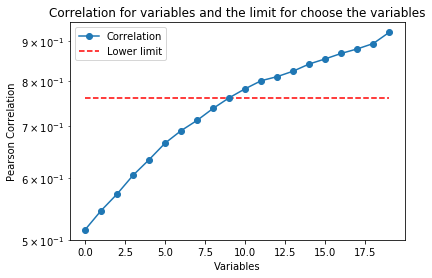

In [9]:
pearson_corr = []

#calculate the correlation between each variable and the output
for column in range(len(X_train[0,:])):
    pearson_corr.append([column, np.corrcoef(X_train[:,column], Y_train)[0,1]])

pearson_corr = np.array(pearson_corr)

# Select the variable with the biggest correlation
selected_variables_corr = (pearson_corr[np.argsort(pearson_corr[:,1])][-1:0:-1][:len(best_predictor['variables'])])
print("Selected variables: \n%s" % selected_variables_corr[:,0].astype(int))

%matplotlib inline
plt.plot(pearson_corr[:,0],pearson_corr[:,1],marker='o', label='Correlation')
plt.hlines(selected_variables_corr[-1,1], 0, 19, colors='red', linestyles='dashed', label='Lower limit')
plt.legend()
plt.title('Correlation for variables and the limit for choose the variables')

plt.yscale('log')
plt.xlabel('Variables')
plt.ylabel('Pearson Correlation')
plt.show()

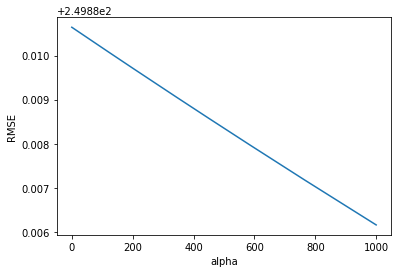

Selected alpha: 2.499e+02


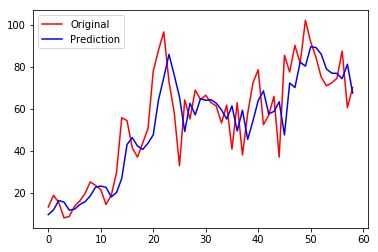

Test dataset
Mean Squared Error: 194.129441 
R2: 0.698480


In [10]:
ALPHA_LIST = np.logspace(-20,3,200)
kf = KFold(n_splits=5)

find_alpha=[]
for alpha in ALPHA_LIST:
    lrr = Ridge(alpha=alpha)
    error_kf=[]
    for train, test in kf.split(X_train):
        lrr.fit(X_train[train][:,selected_variables_corr[:,0].astype(int)],Y_train[train])
        error_kf.append(mean_squared_error(Y_train[test],lrr.predict(X_train[test][:,selected_variables_corr[:,0].astype(int)])))
    find_alpha.append([alpha, np.mean(error_kf)])

find_alpha = np.array(find_alpha)

# Plot the alpha x RMSE finded with cross validation strategy 
%matplotlib inline
plt.plot(find_alpha[:,0],find_alpha[:,1])

plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.show()

print("Selected alpha: %.3e" % min(find_alpha[:,1]))

# train the Ridge Regression for all training data with the best alpha finded before
lrr = Ridge(alpha=min(find_alpha[:,1]))
lrr.fit(X_train[:,selected_variables_corr[:,0].astype(int)],Y_train)

y_pred = lrr.predict(X_test[:,selected_variables_corr[:,0].astype(int)])

#plot the original data and the predict one
%matplotlib inline

plt.plot(Y_test, color='red', label='Original')
plt.plot(y_pred, color='blue', label='Prediction')
plt.legend()
plt.show()

print("Test dataset")
print("Mean Squared Error: %f \nR2: %f" % (mean_squared_error(Y_test,y_pred), r2_score(Y_test,y_pred)))

As variáveis encontradas utilizando a metodologia de filtro foram as últimas 11 observações o que faz sentido, já que são as mais recentes em relação ao que pretende-se observar. E utilizando esta estratégia, encontrou-se uma resposta um pouco melhor do que a alcançada utilizando regressão linear simples, ridge regression com e sem wrapper. Isso pode ter acontecido, pois as estratégias anteriores não obtiveram êxito em generalizar o problema.